In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jrand
import jax.scipy as jsp

import circuitmap as cm
from circuitmap.neural_waveform_demixing import _sample_gp

# Simulated photocurrent based on Schoeters et al

In [2]:
from pc_subtractr_network import Subtractr
import photocurrent_sim
import pc_subtractr_network

argstr = "--num_train 100 --num_test 5 --target_gp_scale 0.05 --pc_scale_max 30.0 --num_traces_per_expt 32 --tau_o_min 3 --tau_o_max 10 --tau_r_min 25 --tau_r_max 30".split(" ")
args = pc_subtractr_network.parse_args(argstr)

subtractr = Subtractr(**vars(args))
subtractr.generate_training_data(args)

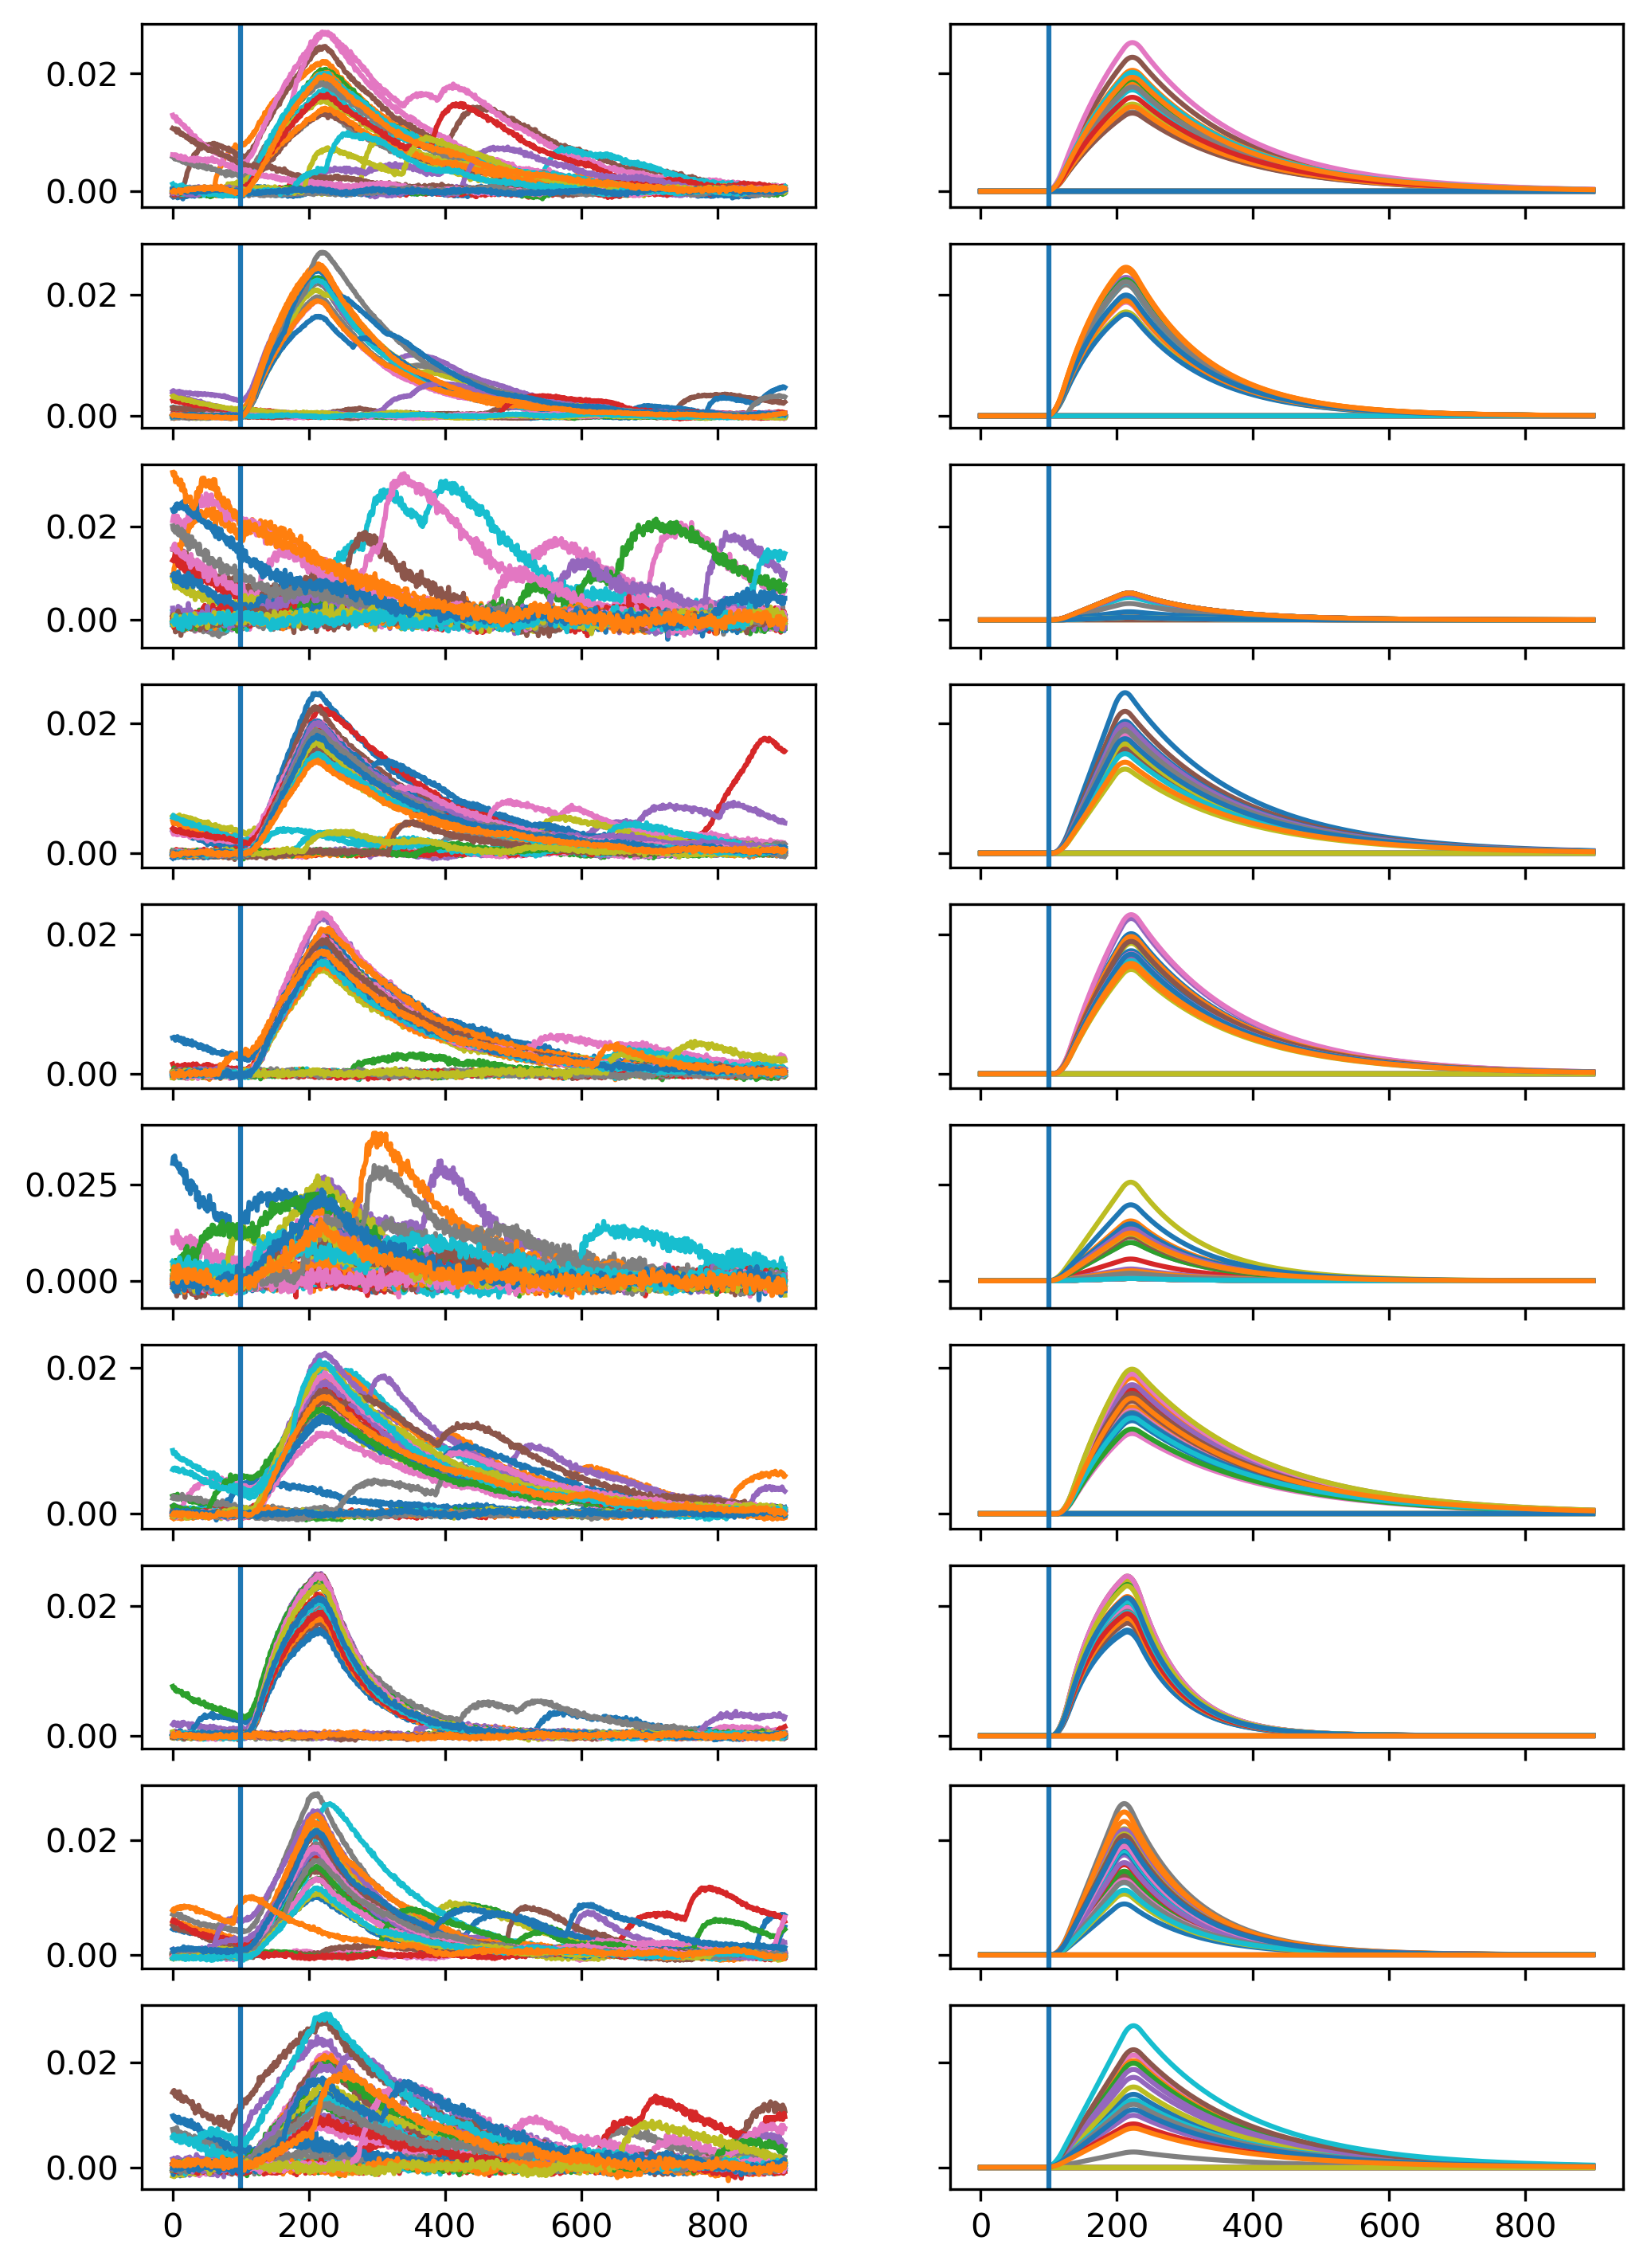

In [3]:
num_to_plot = 10
fig, axs = plt.subplots(nrows=num_to_plot, ncols=2, figsize=(8,12), dpi=300, sharex=True, sharey='row')

obs, targets = subtractr.train_expts
for i in range(num_to_plot):
    obs_curr, targets_curr = obs[i], targets[i]
    # maxv = np.max(obs_curr, axis=-1, keepdims=True)
    # obs_curr /= maxv
    # targets_curr /= maxv
    axs[i,0].plot(obs_curr.T)
    axs[i,1].plot(targets_curr.T)

    axs[i,0].axvline(x=100)
    axs[i,1].axvline(x=100)


In [25]:
subtractr_trained = Subtractr.load_from_checkpoint('./grid_artifacts/tidy-turing-6773/epoch=29-step=300000.ckpt')

Running photocurrent removal...complete (elapsed time 0.24s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.10s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.09s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.09s, device=cpu).


Text(0.5, 1.0, 'gt')

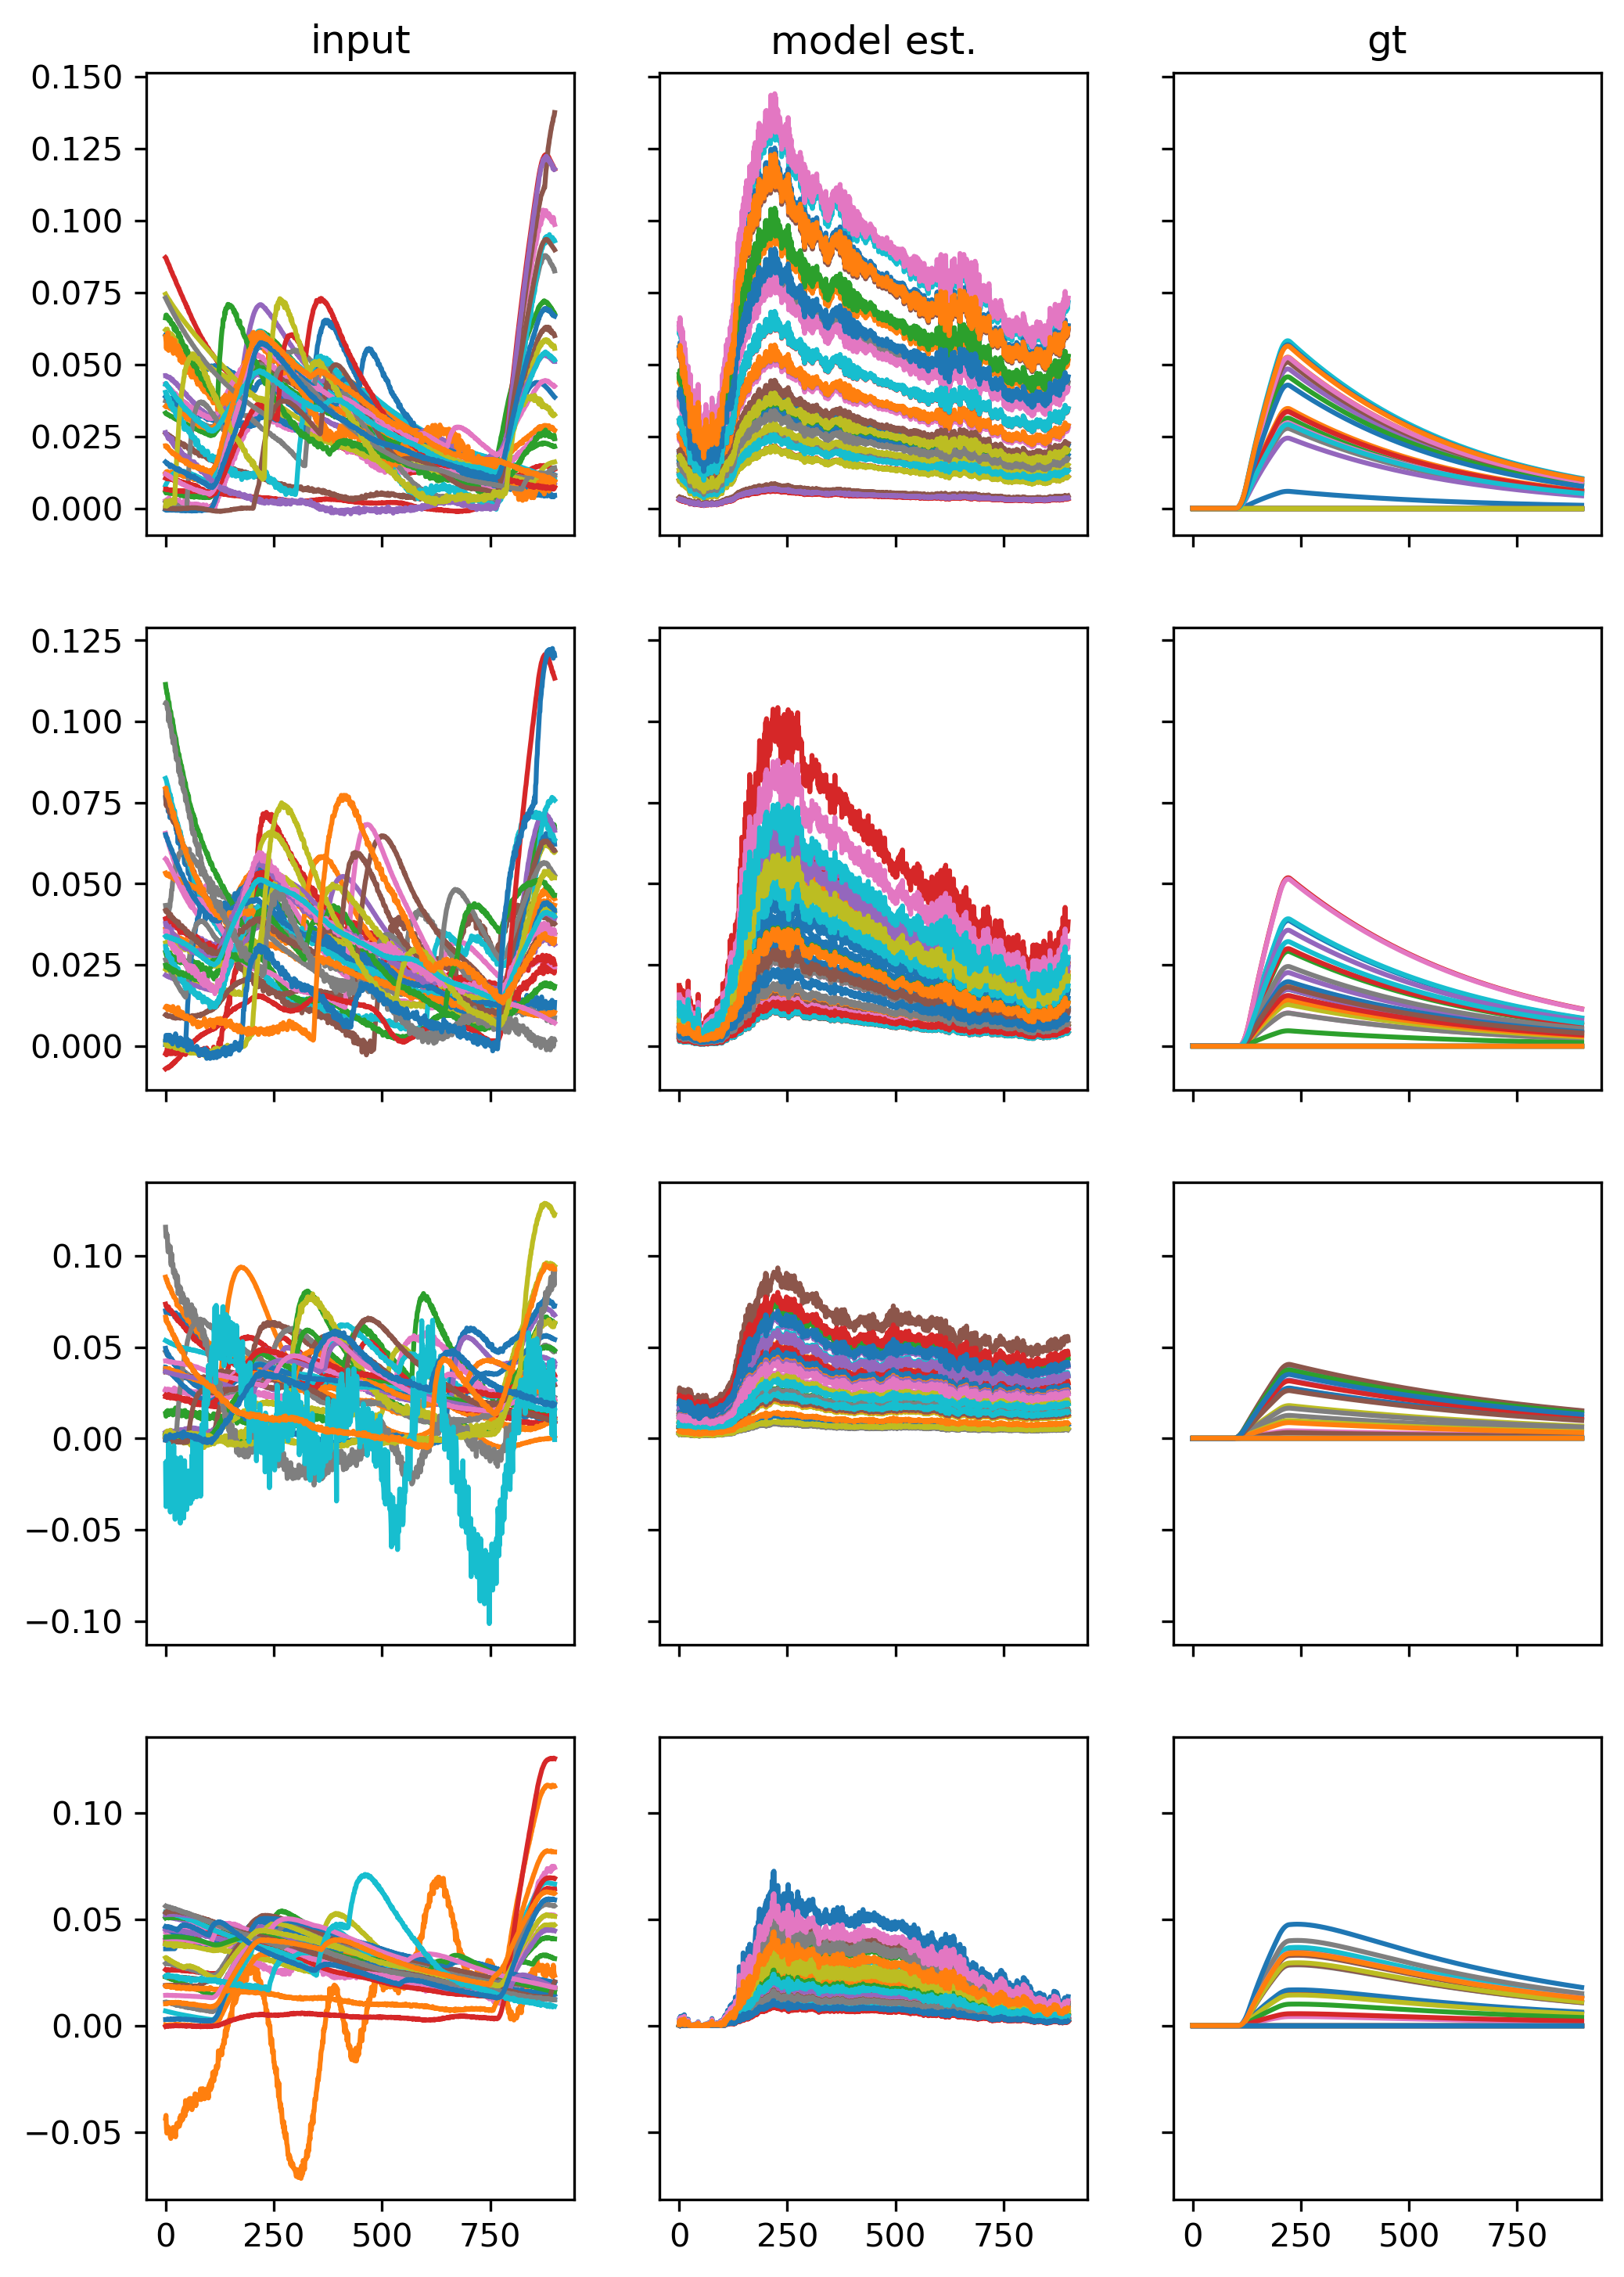

In [21]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8,12), dpi=300, sharex='all', sharey='row', facecolor='white')

obs, targets = subtractr.test_expts
for i in range(4):
    obs_curr, targets_curr = obs[i], targets[i]
    out = subtractr_trained(np.array(obs_curr), batch_size=32)
    maxv = np.max(obs_curr, axis=-1, keepdims=True)
    
    axs[i,0].plot(obs_curr.T)
    axs[i,1].plot(out.T)
    axs[i,2].plot(targets_curr.T)

axs[0,0].set_title('input')
axs[0,1].set_title('model est.')
axs[0,2].set_title('gt')




In [4]:
import sys
sys.path.append('../')
import grid_utils as util
pscs, _, _, _ = util.load_h5_data('../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_OpsPositive_A_grid_cmReformat.mat')

In [7]:
ests = subtractr_trained(pscs, batch_size=32, use_auto_batch_size=False)

Running photocurrent removal...complete (elapsed time 106.24s, device=cpu).


In [5]:
idxs = np.argsort(np.linalg.norm(pscs, axis=-1))

pscs = pscs[idxs]
# ests = ests[idxs]

In [6]:
idxs

array([  155,  4453,  4896, ..., 10624, 13730, 14539])

Text(0.5, 1.0, 'est.')

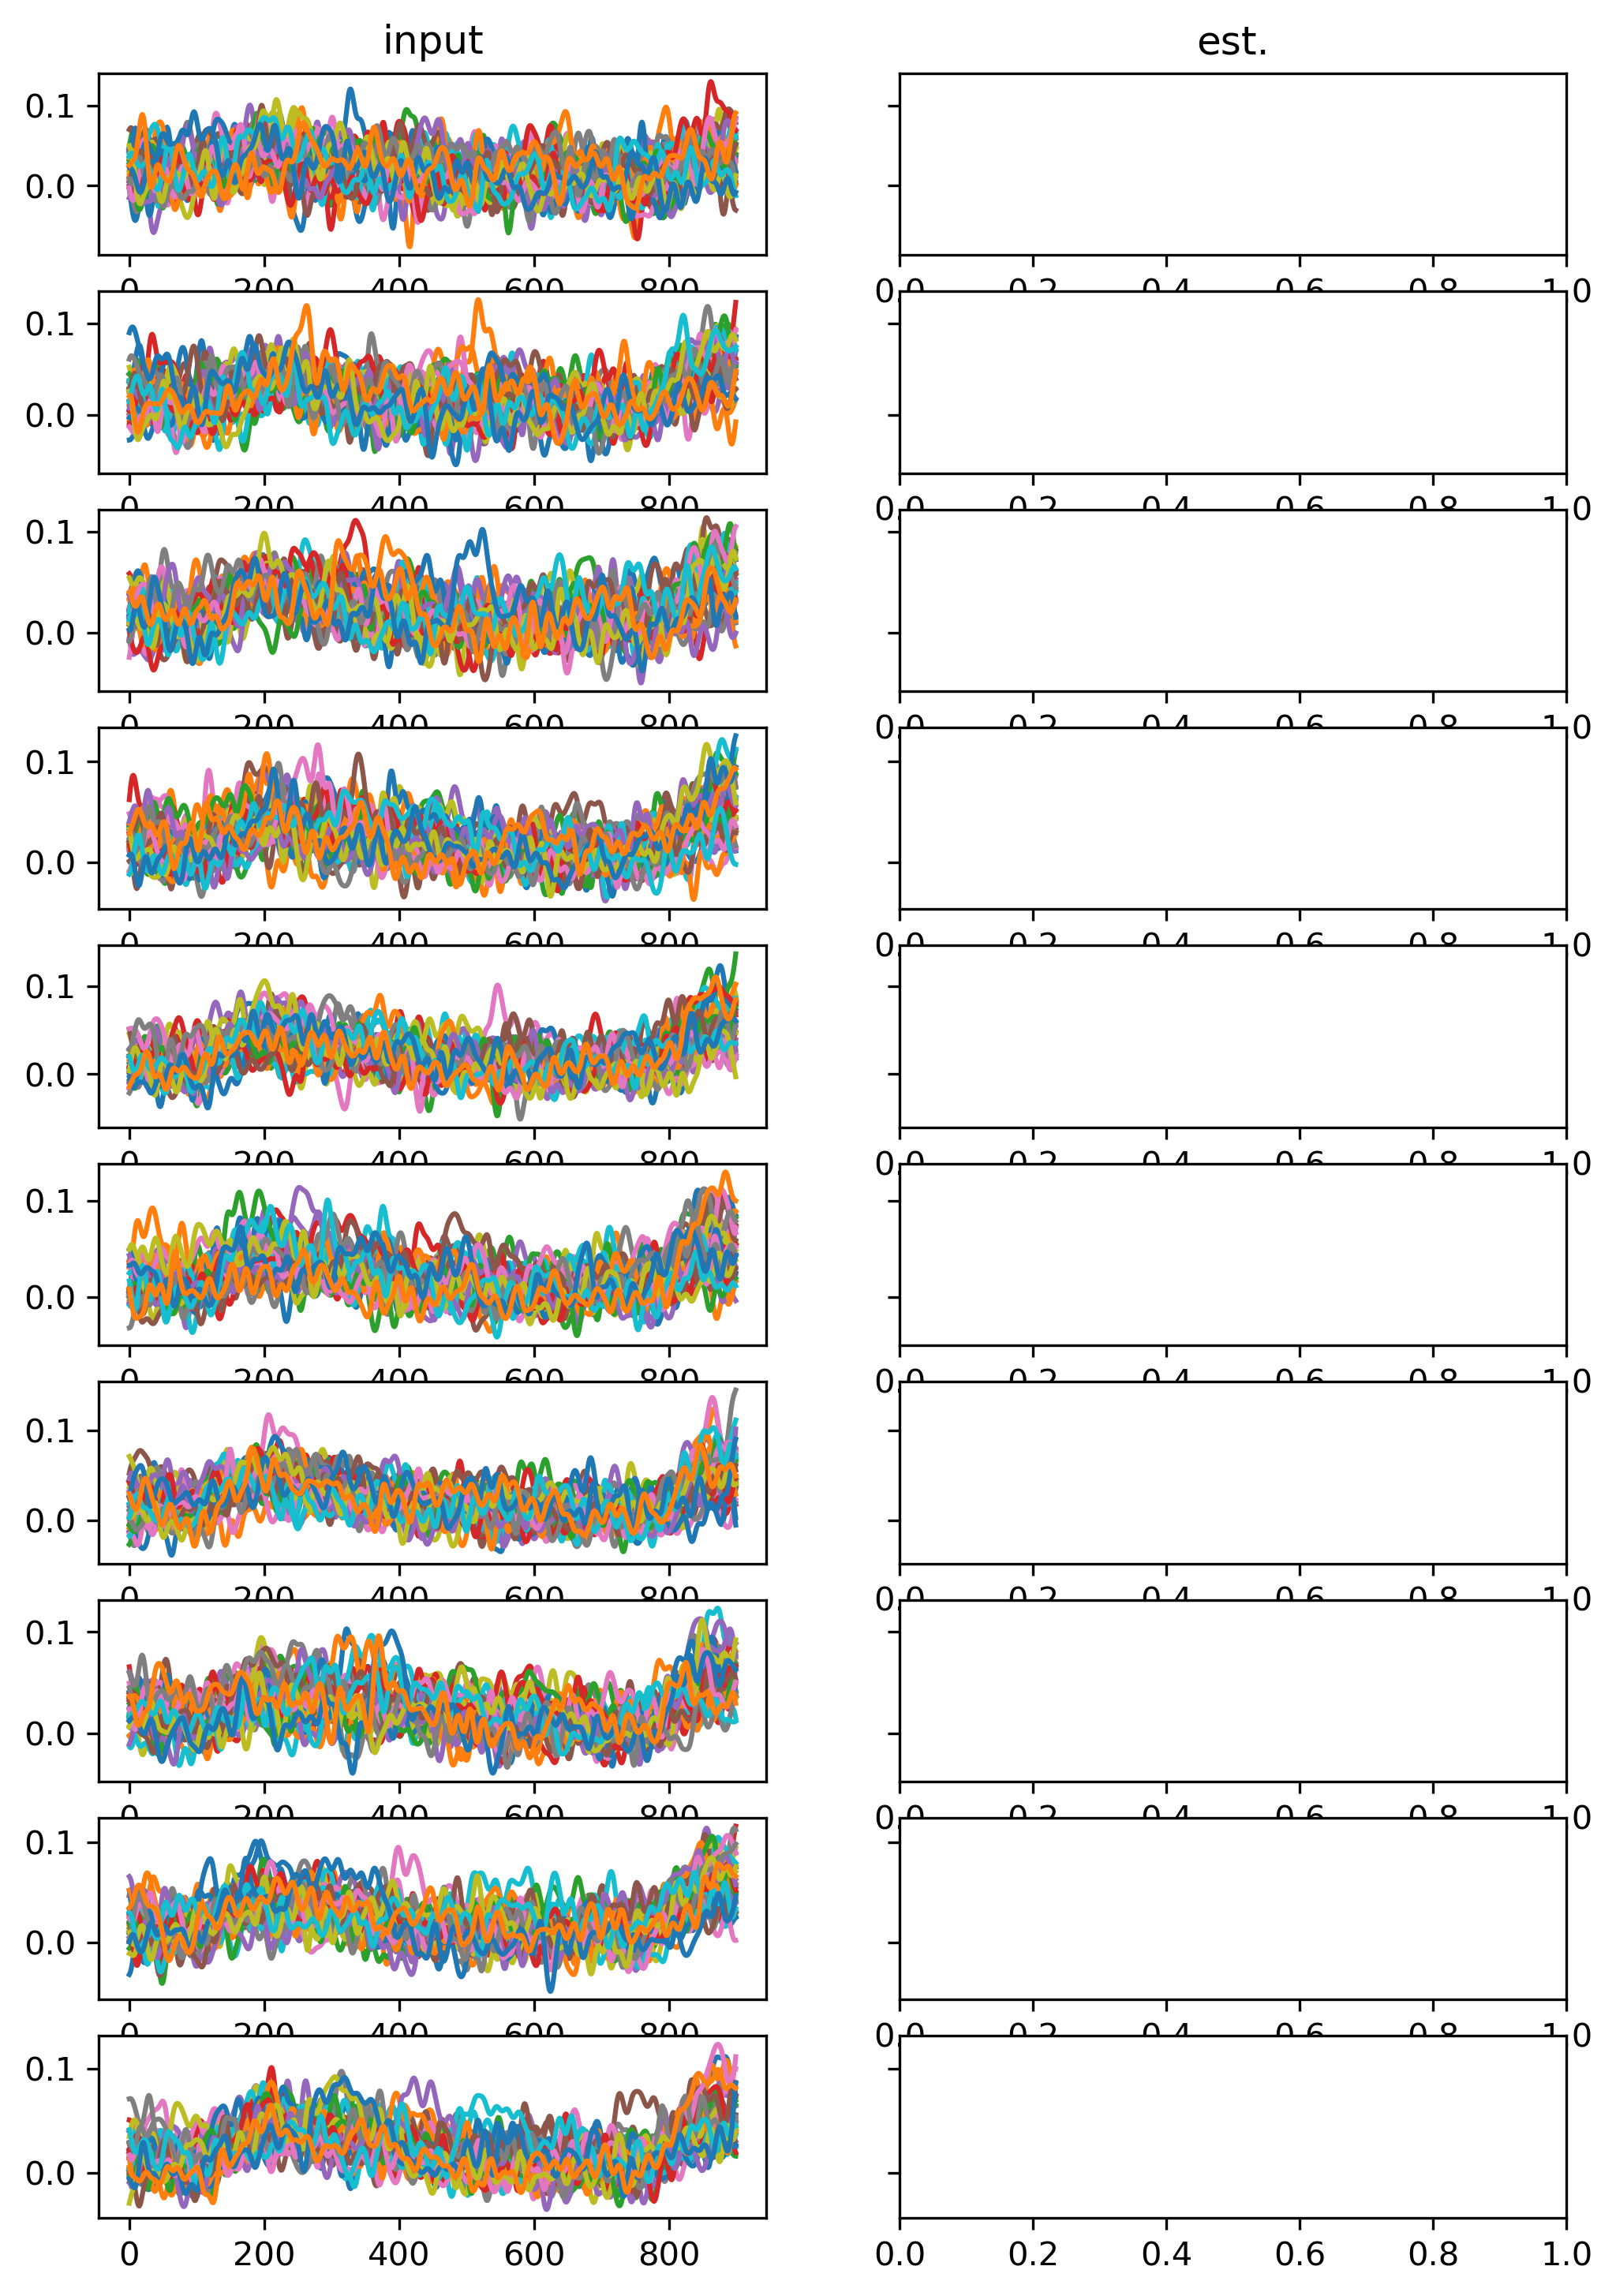

In [7]:
num_batches_to_show = 10

fig, axs = plt.subplots(num_batches_to_show, 2, figsize=(8, 12), sharey='row', dpi=300, facecolor='white')
pscs_batched = np.split(pscs, np.arange(0, pscs.shape[0], 32))
for i in range(num_batches_to_show):
    these_pscs = pscs_batched[i + 1]
    these_pscs /= np.linalg.norm(these_pscs, axis=-1, keepdims=True)
    # out = subtractr_trained(these_pscs, use_auto_batch_size=False, batch_size=-1)

    axs[i,0].plot(these_pscs.T)
    # axs[i,1].plot(out.T)

axs[0,0].set_title('input')
axs[0,1].set_title('est.')

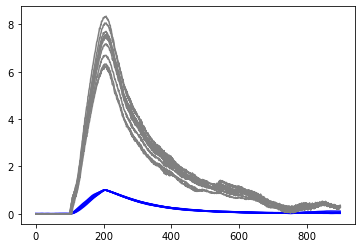

In [10]:
plt.plot(pscs[0:10].T, color='blue')
plt.plot(ests[0:10].T, color='grey')

In [11]:
subtractr_trained.hparams['num_traces_per_expt']

32